In [1]:
import logging

# Set up logging only once
log = logging.getLogger("notebook")
log.setLevel(logging.INFO)

# Avoid duplicate handlers in re-run
if not log.handlers:
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        "[%(asctime)s] [%(levelname)s] %(message)s", "%H:%M:%S"
    )
    handler.setFormatter(formatter)
    log.addHandler(handler)

# Scaled RoPE

In [30]:
from typing import Optional

import torch

def precompute_rope_params(
    context_length: int,
    head_dim: int,
    theta_base: float = 50000.0,
    freq_config: Optional[dict] = None,
):
    """
    Precompute sin and cos tensors for RoPE with optional frequency scaling/smoothing.

    Args:
        context_length: sequence length
        head_dim: embedding dimension (must be even)
        theta_base: base for inverse frequency calculation (default 10_000)
        freq_config: optional dict with keys:
            - original_context_length: int, original training context length
            - low_freq_factor: float, low freq threshold factor (>1)
            - high_freq_factor: float, high freq threshold factor (>1)
            - factor: float, scaling factor (>1)

    Returns:
        sin, cos: tensors of shape (seq_len, head_dim)
    """
    assert head_dim % 2 == 0, "head_dim must be even"

    half_dim = head_dim // 2
    # Compute inverse frequencies
    inv_freq = 1.0 / (theta_base ** (torch.arange(half_dim, dtype=torch.float32) / half_dim))

    if freq_config is not None:
        # Extract frequency config params
        orig_len = freq_config["original_context_length"]
        low_factor = freq_config["low_freq_factor"]
        high_factor = freq_config["high_freq_factor"]
        scale_factor = freq_config["factor"]

        # Compute wavelength
        wavelen = 2 * torch.pi / inv_freq

        low_wavelen = orig_len / low_factor
        high_wavelen = orig_len / high_factor

        # Scale inverse freq for low freq bands
        condition = wavelen > low_wavelen  # 明确生成一个 Tensor
        inv_freq_scaled = torch.where(condition, inv_freq / scale_factor, inv_freq)

        # Compute smooth factor for medium freq band
        smooth_factor = (orig_len / wavelen - low_factor) / (high_factor - low_factor)
        smooth_factor = smooth_factor.clamp(0.0, 1.0)

        smoothed_inv_freq = (1 - smooth_factor) * (inv_freq / scale_factor) + smooth_factor * inv_freq

        is_medium = (wavelen <= low_wavelen) & (wavelen >= high_wavelen)
        inv_freq = torch.where(is_medium, smoothed_inv_freq, inv_freq_scaled)

    positions = torch.arange(context_length, dtype=torch.float32)
    angles = torch.einsum("i,j->ij", positions, inv_freq)  # (seq_len, half_dim)
    return torch.sin(angles), torch.cos(angles)

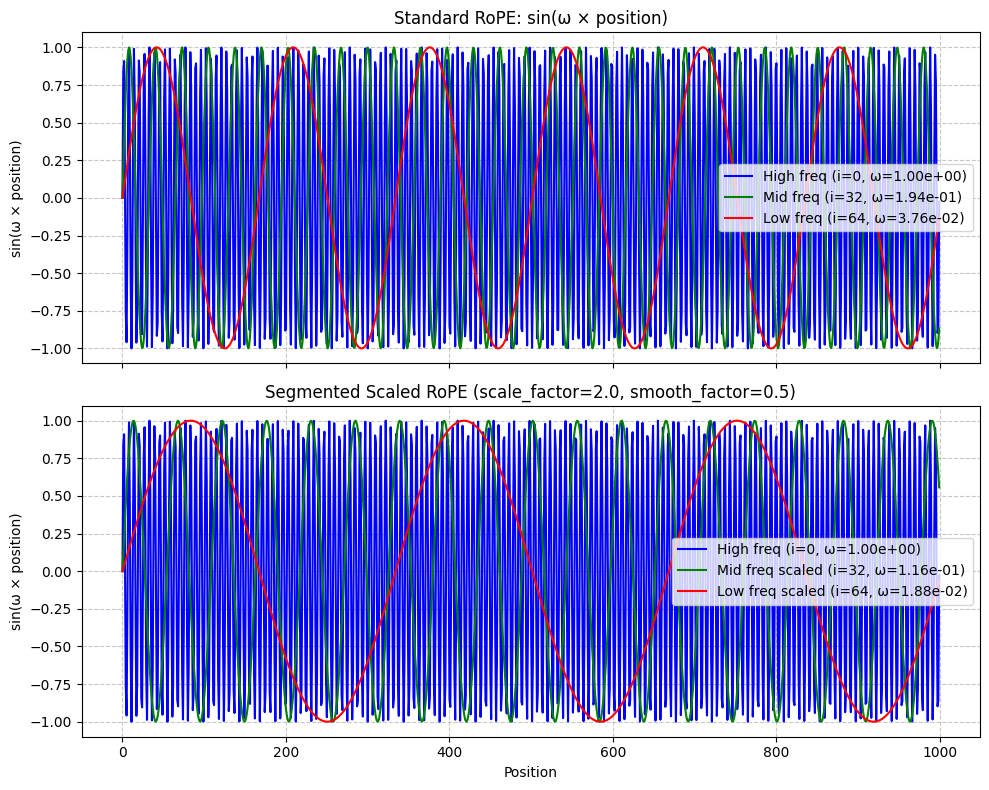

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
base = 500000  # RoPE base used in LLaMA 3
scale_factor = 2.0  # Scaling factor for low frequencies
d = 512        # Total embedding dimension
positions = np.arange(0, 1000)  # Token position range

# Frequency index range: 0 to d/2 - 1 (each frequency corresponds to 2 embedding dims)
i_high = 0      # High frequency (fast variation, low dimension index)
i_mid  = 32    # Mid frequency
i_low  = 64    # Low frequency (slow variation, high dimension index)

# Calculate corresponding angular frequency ω_i = 1 / base^{2i/d}
def calc_omega(i):
    return 1 / (base ** (2 * i / d))

omega_high = calc_omega(i_high)
omega_mid = calc_omega(i_mid)
omega_low = calc_omega(i_low)

# Piecewise scaling
omega_high_scaled = omega_high  # High frequency remains unchanged
smooth_factor = 0.5             # Interpolation factor between mid and low frequencies
omega_mid_scaled = smooth_factor * omega_mid + (1 - smooth_factor) * omega_low
omega_low_scaled = omega_low / scale_factor  # Scale down low frequency (make frequency smaller, wavelength longer)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Standard RoPE plot
ax1.plot(positions, np.sin(omega_high * positions), label=f'High freq (i={i_high}, ω={omega_high:.2e})', color='blue')
ax1.plot(positions, np.sin(omega_mid * positions), label=f'Mid freq (i={i_mid}, ω={omega_mid:.2e})', color='green')
ax1.plot(positions, np.sin(omega_low * positions), label=f'Low freq (i={i_low}, ω={omega_low:.2e})', color='red')
ax1.set_title("Standard RoPE: sin(ω × position)")
ax1.set_ylabel("sin(ω × position)")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Scaled RoPE plot
ax2.plot(positions, np.sin(omega_high_scaled * positions), label=f'High freq (i={i_high}, ω={omega_high_scaled:.2e})', color='blue')
ax2.plot(positions, np.sin(omega_mid_scaled * positions), label=f'Mid freq scaled (i={i_mid}, ω={omega_mid_scaled:.2e})', color='green')
ax2.plot(positions, np.sin(omega_low_scaled * positions), label=f'Low freq scaled (i={i_low}, ω={omega_low_scaled:.2e})', color='red')
ax2.set_title(f"Segmented Scaled RoPE (scale_factor={scale_factor}, smooth_factor={smooth_factor})")
ax2.set_xlabel("Position")
ax2.set_ylabel("sin(ω × position)")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


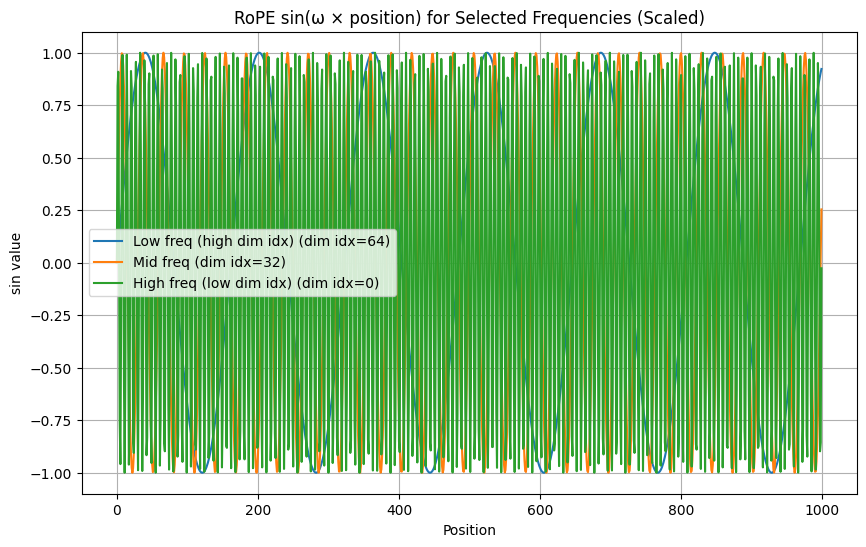

In [34]:
import matplotlib.pyplot as plt
import torch

# 先定义 freq_config，模拟 LLaMA3 的缩放配置
freq_config = {
    "original_context_length": 2048,
    "low_freq_factor": 1.0,
    "high_freq_factor": 128.0,
    "factor": 2.0,  # 缩放因子
}

context_length = 1000
head_dim = 512
theta_base = 50000.0

# 调用函数计算 sin, cos
sin_vals, cos_vals = precompute_rope_params(
    context_length=context_length,
    head_dim=head_dim,
    theta_base=theta_base,
    freq_config=freq_config,
)

positions = torch.arange(context_length)

# 选择代表性的频率维度索引 (half_dim = head_dim//2 = 256)
indices = {
    "Low freq (high dim idx)": 64,   # 低频，维度最大索引
    "Mid freq": 32,
    "High freq (low dim idx)": 0,     # 高频，维度最小索引
}

plt.figure(figsize=(10, 6))

for label, idx in indices.items():
    plt.plot(
        positions.numpy(),
        sin_vals[:, idx].numpy(),
        label=f"{label} (dim idx={idx})"
    )

plt.title("RoPE sin(ω × position) for Selected Frequencies (Scaled)")
plt.xlabel("Position")
plt.ylabel("sin value")
plt.legend()
plt.grid(True)
plt.show()


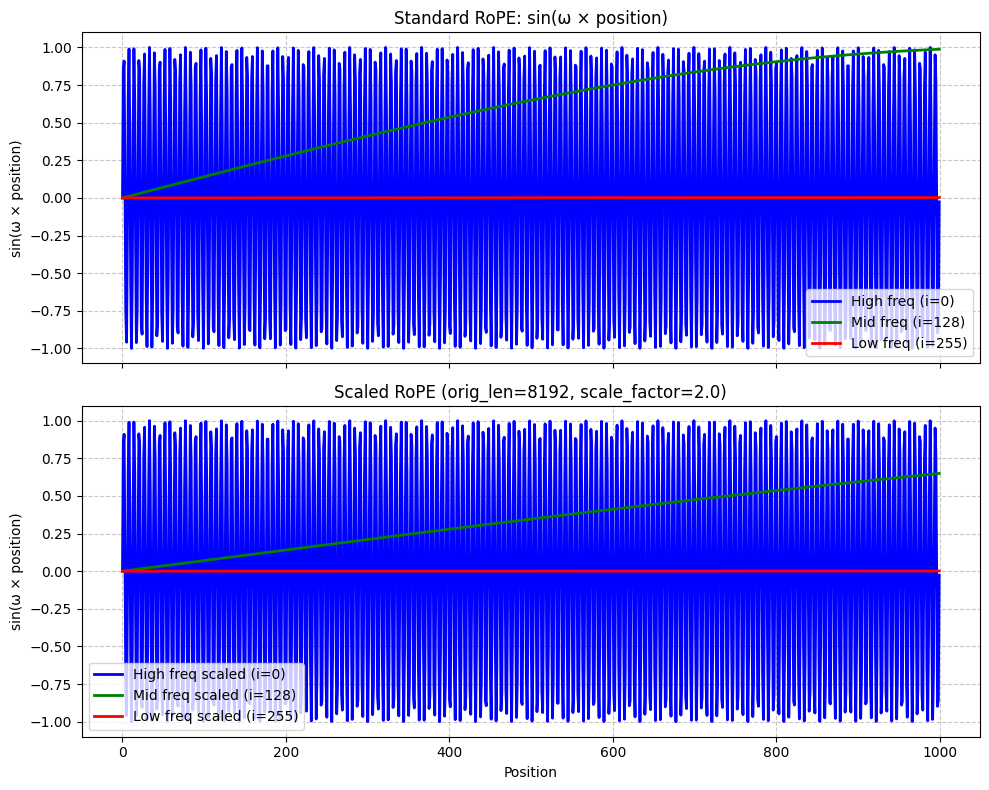

In [35]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def precompute_rope_params(
    context_length: int,
    head_dim: int,
    theta_base: float = 500000.0,  # 修正为LLaMA 3的默认值
    freq_config: Optional[dict] = None,
):
    """
    Precompute sin and cos tensors for RoPE with optional frequency scaling/smoothing.

    Args:
        context_length: sequence length
        head_dim: embedding dimension (must be even)
        theta_base: base for inverse frequency calculation (default 500000)
        freq_config: optional dict with keys:
            - original_context_length: int, original training context length
            - low_freq_factor: float, low freq threshold factor (>1)
            - high_freq_factor: float, high freq threshold factor (>1)
            - factor: float, scaling factor (>1)

    Returns:
        sin, cos: tensors of shape (seq_len, head_dim)
    """
    assert head_dim % 2 == 0, "head_dim must be even"

    half_dim = head_dim // 2
    inv_freq = 1.0 / (theta_base ** (torch.arange(half_dim, dtype=torch.float32) / half_dim))

    if freq_config is not None:
        orig_len = freq_config["original_context_length"]
        low_factor = freq_config["low_freq_factor"]
        high_factor = freq_config["high_freq_factor"]
        scale_factor = freq_config["factor"]

        wavelen = 2 * torch.pi / inv_freq
        low_wavelen = orig_len / low_factor
        high_wavelen = orig_len / high_factor

        condition = wavelen > low_wavelen
        inv_freq_scaled = torch.where(condition, inv_freq / scale_factor, inv_freq)

        smooth_factor = (orig_len / wavelen - low_factor) / (high_factor - low_factor)
        smooth_factor = smooth_factor.clamp(0.0, 1.0)
        smoothed_inv_freq = (1 - smooth_factor) * (inv_freq / scale_factor) + smooth_factor * inv_freq

        is_medium = (wavelen <= low_wavelen) & (wavelen >= high_wavelen)
        inv_freq = torch.where(is_medium, smoothed_inv_freq, inv_freq_scaled)

    positions = torch.arange(context_length, dtype=torch.float32)
    angles = torch.einsum("i,j->ij", positions, inv_freq)  # (seq_len, half_dim)
    return torch.sin(angles), torch.cos(angles)

# 参数设置
context_length = 1000  # 序列长度
head_dim = 512         # embedding维度
theta_base = 500000.0  # LLaMA 3基数
freq_config = {
    "original_context_length": 8192,  # 假设原始训练长度
    "low_freq_factor": 4.0,          # 低频阈值因子
    "high_freq_factor": 2.0,         # 高频阈值因子
    "factor": 2.0                    # 缩放因子
}

# 计算标准RoPE和Scaled RoPE的正弦值
sin_standard, _ = precompute_rope_params(context_length, head_dim, theta_base, freq_config=None)
sin_scaled, _ = precompute_rope_params(context_length, head_dim, theta_base, freq_config=freq_config)

# 选择代表性维度索引
i_high = 0    # 高频（低索引，前半部分）
i_mid = 128   # 中频
i_low = 255   # 低频（高索引，后半部分）

# 创建子图：标准RoPE vs Scaled RoPE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# 子图1：标准RoPE
ax1.plot(sin_standard[:, i_high], label=f'High freq (i={i_high})', linewidth=2, color='blue')
ax1.plot(sin_standard[:, i_mid], label=f'Mid freq (i={i_mid})', linewidth=2, color='green')
ax1.plot(sin_standard[:, i_low], label=f'Low freq (i={i_low})', linewidth=2, color='red')
ax1.set_title("Standard RoPE: sin(ω × position)")
ax1.set_ylabel("sin(ω × position)")
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# 子图2：Scaled RoPE
ax2.plot(sin_scaled[:, i_high], label=f'High freq scaled (i={i_high})', linewidth=2, color='blue')
ax2.plot(sin_scaled[:, i_mid], label=f'Mid freq scaled (i={i_mid})', linewidth=2, color='green')
ax2.plot(sin_scaled[:, i_low], label=f'Low freq scaled (i={i_low})', linewidth=2, color='red')
ax2.set_title(f"Scaled RoPE (orig_len={freq_config['original_context_length']}, scale_factor={freq_config['factor']})")
ax2.set_xlabel("Position")
ax2.set_ylabel("sin(ω × position)")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# 调整布局
plt.tight_layout()
plt.show()

In [3]:
# Instantiate RoPE parameters

llama_3_context_len = 8192
llama_3_theta_base = 500_000

In [4]:
from Llama2_v1 import rotary_pos_emb

# Settings
batch_size = 2
num_heads = 4
head_dim = 16

# Instantiate RoPE parameters
cos, sin = precompute_rope_params(
    head_dim=head_dim,
    theta_base=llama_3_theta_base,
    context_length=llama_3_context_len
)

# Dummy query and key tensors
torch.manual_seed(123)
queries = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)
keys = torch.randn(batch_size, num_heads, llama_3_context_len, head_dim)

# Apply rotary position embeddings
queries_rot = rotary_pos_emb(queries, cos, sin)
keys_rot = rotary_pos_emb(keys, cos, sin)

print("shape of queries:", queries.shape)
print("shape of keys:", keys.shape)

shape of queries: torch.Size([2, 4, 8192, 16])
shape of keys: torch.Size([2, 4, 8192, 16])


# Grouped-query attention

In [5]:
class SharedBuffers:
    _buffers = {}

    @staticmethod
    def get_buffers(context_length, head_dim, rope_base, freq_config, dtype=torch.float32):
        key = (context_length, head_dim, rope_base, tuple(freq_config.values()) if freq_config else freq_config, dtype)

        if key not in SharedBuffers._buffers:
            # Create or fetch the buffers
            mask = torch.triu(torch.ones(context_length, context_length), diagonal=1).bool()
            cos, sin = precompute_rope_params(context_length, head_dim, rope_base, freq_config)
            if dtype is not None:
                cos = cos.to(dtype)
                sin = sin.to(dtype)
            SharedBuffers._buffers[key] = (mask, cos, sin)

        return SharedBuffers._buffers[key]

batch_size = 2
context_len = 3000
max_context_len = 8192
embed_dim = 4096
num_heads = 32
num_kv_groups=8


d_in d_out = 4096
num_heads = 32
num_kv_groups=8
head_dim = d_out/num_heads = 4096/32 = 128
group_size = num_heads/num_kv_groups = 32/8 = 4

所以总维度：
d_out = num_kv_groups * group_size * head_dim = 8 * 4 * 128 = 4096

In [6]:
from torch import nn

class GroupedQueryAttention(nn.Module):
    def __init__(
            self, d_in, d_out, context_length, num_heads,
            num_kv_groups,
            rope_base=10_000,
            rope_config=None,
            dtype=None
        ):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.d_out = d_out
        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.head_dim = d_out // num_heads
        self.group_size = num_heads // num_kv_groups
        log.debug(f"d_out={self.d_out}, num_heads={self.num_heads}, num_kv_groups={self.num_kv_groups}, head_dim={self.head_dim}, group_size={self.group_size}")

        linear_kwargs = dict(bias=False, dtype=dtype)
        self.W_query = nn.Linear(d_in, d_out, **linear_kwargs)
        self.W_key = nn.Linear(d_in, num_kv_groups * self.head_dim, **linear_kwargs)
        self.W_value = nn.Linear(d_in, num_kv_groups * self.head_dim, **linear_kwargs)
        self.out_proj = nn.Linear(d_out, d_out, **linear_kwargs)

        mask, cos, sin = SharedBuffers.get_buffers(
            context_length, self.head_dim, rope_base, rope_config, dtype
        )
        self.register_buffer("mask", mask)
        self.register_buffer("cos", cos)
        self.register_buffer("sin", sin)

    def forward(self, x):
        b, seq_len, _ = x.shape
        log.debug("shape of x: %s", x.shape)

        queries = self.W_query(x).view(b, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        keys = self.W_key(x).view(b, seq_len, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = self.W_value(x).view(b, seq_len, self.num_kv_groups, self.head_dim).transpose(1, 2)
        log.debug("shape of queries: %s", queries.shape)
        log.debug("shape of keys: %s", keys.shape)

        # self.cos = self.cos[:seq_len, :self.head_dim // 2].unsqueeze(0).unsqueeze(0)  # (1, 1, L, D//2)
        # self.sin = self.sin[:seq_len, :self.head_dim // 2].unsqueeze(0).unsqueeze(0)
        # assert cos.ndim == 4, f"cos has wrong shape: {cos.shape}"
        # log.debug("shape of cos: %s", self.cos.shape)


        # Apply rotary positional embeddings
        queries = rotary_pos_emb(queries, self.cos, self.sin)
        keys = rotary_pos_emb(keys, self.cos, self.sin)
        log.debug("shape of queries: %s", queries.shape)

        # Repeat keys and values to match num_heads
        keys = keys.repeat_interleave(self.group_size, dim=1)  # (b, num_heads, seq_len, head_dim)
        values = values.repeat_interleave(self.group_size, dim=1)
        log.debug("shape of keys: %s", keys.shape)
        log.debug("shape of values: %s", values.shape)

        # Compute attention scores with causal mask
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1))
        mask_bool = self.mask.bool()[:seq_len, :seq_len]
        attn_scores = attn_scores.masked_fill(mask_bool, -torch.inf)
        log.debug("shape of attn_scores: %s", attn_scores.shape)

        attn_weights = torch.softmax(attn_scores / (self.head_dim ** 0.5), dim=-1)
        log.debug("shape of attn_weights: %s", attn_weights.shape)
        assert keys.shape[-1] == self.head_dim

        context = torch.matmul(attn_weights, values)  # (b, num_heads, seq_len, head_dim)
        log.debug("shape of context: %s", context.shape)
        context = context.transpose(1, 2).reshape(b, seq_len, self.d_out)
        log.debug("shape of context: %s", context.shape)

        out = self.out_proj(context)
        log.debug("shape of out: %s", out.shape)
        return out

In [7]:
batch_size = 2
context_len = 3000
max_context_len = 8192
embed_dim = 4096
num_heads = 32

example_batch = torch.randn((batch_size, context_len, embed_dim))

gqa = GroupedQueryAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads,
    num_kv_groups=8,
    rope_base=llama_3_theta_base
)

gqa(example_batch)

print("W_query:", gqa.W_query.weight.shape)
print("W_key:", gqa.W_key.weight.shape)
print("W_value:", gqa.W_value.weight.shape)

W_query: torch.Size([4096, 4096])
W_key: torch.Size([1024, 4096])
W_value: torch.Size([1024, 4096])


In [8]:
from Llama2_v1 import MultiHeadAttention

batch_size = 2
context_len = 3000
max_context_len = 8192
embed_dim = 4096
num_heads = 32

example_batch = torch.randn((batch_size, context_len, embed_dim))

mha = MultiHeadAttention(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=max_context_len,
    num_heads=num_heads
)

mha(example_batch)

print("W_query:", mha.W_query.weight.shape)
print("W_key:", mha.W_key.weight.shape)
print("W_value:", mha.W_value.weight.shape)

W_query: torch.Size([4096, 4096])
W_key: torch.Size([4096, 4096])
W_value: torch.Size([4096, 4096])


In [9]:
print("Total number of parameters:")

mha_total_params = sum(p.numel() for p in mha.parameters())
print(f"MHA: {mha_total_params:,}")

gqa_total_params = sum(p.numel() for p in gqa.parameters())
print(f"GQA: {gqa_total_params:,}")

Total number of parameters:
MHA: 67,108,864
GQA: 41,943,040


In [10]:
del mha
del gqa

# Update Transformer Block with GQA

In [11]:
from Llama2_v1 import FeedForward, RMSNorm

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            num_kv_groups=cfg["n_kv_groups"],  # NEW
            rope_base=cfg["rope_base"],        # NEW
            rope_config=cfg["rope_freq"],      # NEW
            dtype=cfg["dtype"]
        )
        self.ff = FeedForward(cfg)

        self.norm1 = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.norm2 = RMSNorm(cfg["emb_dim"], eps=1e-5)
    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x + shortcut  # Add the original input back

        return x

# Update Model

In [12]:
class Llama3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = RMSNorm(cfg["emb_dim"], eps=1e-5)
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

    def forward(self, in_idx):
        x = self.tok_emb(in_idx)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x.to(torch.bfloat16))
        return logits

# Initialize Model

In [13]:
LLAMA3_CONFIG_8B = {
    "vocab_size": 128_256,   # NEW: Larger vocabulary size
    "context_length": 8192,  # NEW: Larger context length
    "emb_dim": 4096,         # Embedding dimension
    "n_heads": 32,           # Number of attention heads
    "n_layers": 32,          # Number of layers
    "hidden_dim": 14_336,    # NEW: Larger size of the intermediate dimension in FeedForward
    "n_kv_groups": 8,        # NEW: Key-Value groups for grouped-query attention
    "rope_base": 500_000.0,  # NEW: The base in RoPE's "theta" was increased to 500_000
    "rope_freq": None,       # NEW: Additional configuration for adjusting the RoPE frequencies
    "dtype": torch.bfloat16  # Lower-precision dtype to reduce memory usage
}

In [14]:
model = Llama3Model(LLAMA3_CONFIG_8B)

In [15]:
# Check buffers
print(model.trf_blocks[0].att.mask is model.trf_blocks[-1].att.mask)
print(model.trf_blocks[0].att.cos is model.trf_blocks[-1].att.cos)
print(model.trf_blocks[0].att.sin is model.trf_blocks[-1].att.sin)

True
True
True


In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 8,030,261,248


In [17]:
def model_memory_size(model, input_dtype=torch.float32):
    element_size = torch.tensor([], dtype=input_dtype).element_size()
    total_elements = sum(p.numel() * (1 + int(p.requires_grad)) for p in model.parameters())
    total_elements += sum(b.numel() for b in model.buffers())
    return total_elements * element_size / (1024 ** 3)

print(f"float32 (PyTorch default): {model_memory_size(model, torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, torch.bfloat16):.2f} GB")


float32 (PyTorch default): 60.08 GB
bfloat16: 30.04 GB


In [18]:
def model_memory_size(model, input_dtype=torch.float32):
    total_params = 0
    total_grads = 0
    for param in model.parameters():
        # Calculate total number of elements per parameter
        param_size = param.numel()
        total_params += param_size
        # Check if gradients are stored for this parameter
        if param.requires_grad:
            total_grads += param_size

    # Calculate buffer size (non-parameters that require memory)
    total_buffers = sum(buf.numel() for buf in model.buffers())

    # Size in bytes = (Number of elements) * (Size of each element in bytes)
    # We assume parameters and gradients are stored in the same type as input dtype
    element_size = torch.tensor(0, dtype=input_dtype).element_size()
    total_memory_bytes = (total_params + total_grads + total_buffers) * element_size

    # Convert bytes to gigabytes
    total_memory_gb = total_memory_bytes / (1024**3)

    return total_memory_gb

print(f"float32 (PyTorch default): {model_memory_size(model, input_dtype=torch.float32):.2f} GB")
print(f"bfloat16: {model_memory_size(model, input_dtype=torch.bfloat16):.2f} GB")

float32 (PyTorch default): 60.08 GB
bfloat16: 30.04 GB


In [19]:
device = torch.device("cpu")
model.to(device);


# Load Tokenizer

LLaMA 3 自己定义了一个 BPE（Byte Pair Encoding）文件，而不是使用 OpenAI 的 cl100k_base、p50k_base、r50k_base。

tiktoken.get_encoding() 是针对 OpenAI 预设模型，例如 GPT-3.5、GPT-4 的 tokenizer。

所以，LLaMA 3 的 tokenizer 必须显式加载自己的 merge rules，不能使用默认的 tokenizer。

LLaMA 使用了和 GPT 不同的分词规则（regex pattern）来进行 tokenization。

这是为了 更适配 LLaMA 的训练数据特性，比如对 Unicode 字符、换行、标点的处理更细致。

所以必须自定义 pat_str，不能使用 tiktoken.get_encoding 提供的固定版本。

In [20]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe


class Tokenizer:
    """
    Tokenizer wrapper for LLaMA 3 using custom tiktoken BPE files.

    Automatically loads custom merge rules, special tokens, and regex-based tokenization pattern.
    """

    def __init__(self, model_path: str):
        """
        Initialize the tokenizer with a given BPE model file.

        Args:
            model_path (str): Path to the .tiktoken file used by LLaMA 3.
        """
        model_path = Path(model_path)
        if not model_path.is_file():
            raise FileNotFoundError(f"Tokenizer model file not found: {model_path}")

        # Load mergeable BPE ranks from file
        mergeable_ranks = load_tiktoken_bpe(str(model_path))

        # Define special token IDs
        special_tokens = {
            "<|begin_of_text|>": 128000,
            "<|end_of_text|>": 128001,
            "<|start_header_id|>": 128006,
            "<|end_header_id|>": 128007,
            "<|eot_id|>": 128009,
        }

        # Add reserved special tokens from 128002 to 128257 (excluding used IDs)
        special_tokens.update({
            f"<|reserved_{i}|>": 128002 + i
            for i in range(256)
            if (128002 + i) not in special_tokens.values()
        })

        # Regex pattern string used for LLaMA-style tokenization
        pat_str = (
            r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|"
            r"[^\r\n\p{L}\p{N}]?\p{L}+|"
            r"\p{N}{1,3}|"
            r" ?[^\s\p{L}\p{N}]+[\r\n]*|"
            r"\s*[\r\n]+|"
            r"\s+(?!\S)|"
            r"\s+"
        )

        self.special_tokens = special_tokens

        # Create the tiktoken Encoding instance
        self.model = tiktoken.Encoding(
            name=model_path.name,
            pat_str=pat_str,
            mergeable_ranks=mergeable_ranks,
            special_tokens=special_tokens,
        )

    def encode(self, text: str, bos: bool = False, eos: bool = False,
               allowed_special: set = set(), disallowed_special=()) -> list[int]:
        """
        Encode a text string into token IDs.

        Args:
            text (str): Input string to tokenize.
            bos (bool): Whether to prepend <|begin_of_text|> token.
            eos (bool): Whether to append <|end_of_text|> token.
            allowed_special (set): Set of allowed special token strings.
            disallowed_special: Set or policy for disallowed tokens.

        Returns:
            List[int]: Token ID list.
        """
        tokens = []
        if bos:
            tokens.append(self.special_tokens["<|begin_of_text|>"])

        tokens += self.model.encode(
            text,
            allowed_special=allowed_special,
            disallowed_special=disallowed_special
        )

        if eos:
            tokens.append(self.special_tokens["<|end_of_text|>"])
        return tokens

    def decode(self, tokens: list[int]) -> str:
        """
        Decode a list of token IDs back into text.

        Args:
            tokens (List[int]): Token ID list.

        Returns:
            str: Decoded string.
        """
        return self.model.decode(tokens)


In [21]:
from pathlib import Path
from huggingface_hub import hf_hub_download

def download_tokenizer_if_needed(repo_id: str, filename: str, local_dir: str) -> str:
    local_path = Path(local_dir) / filename
    if local_path.exists():
        print(f"Tokenizer file {local_path} already exists, skipping.")
        return str(local_path)

    return hf_hub_download(
        repo_id=repo_id,
        filename=filename,
        local_dir=local_dir
    )

# Example usage
tokenizer_file_path = download_tokenizer_if_needed(
    repo_id="meta-llama/Meta-Llama-3-8B",
    filename="original/tokenizer.model",
    local_dir="Llama-3-8B"
)


/Users/bytedance/PycharmProjects/CreateYourOwnLLM/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/bytedance/PycharmProjects/CreateYourOwnLLM/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tokenizer file Llama-3-8B/original/tokenizer.model already exists, skipping.


In [22]:
tokenizer = Tokenizer(tokenizer_file_path)

In [23]:
# Encode with BOS and EOS tokens
tokens = tokenizer.encode("Hello world!", bos=True, eos=True)
print(tokens)

# Decode back to text
text = tokenizer.decode(tokens)
print(text)


[128000, 9906, 1917, 0, 128001]
<|begin_of_text|>Hello world!<|end_of_text|>


In [24]:
from Llama2_v1 import generate_text_simple, text_to_tensor, tensor_to_text

torch.manual_seed(123)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor("At the start of", tokenizer).to("cpu"),
    max_new_tokens=30,
    context_size=LLAMA3_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", tensor_to_text(token_ids, tokenizer))

Output text:
 At the start offiveBoundingClientRect(wp\: Poverty Columbiaebiliriz786.Assertions theories bỏアหมายITO_flat.Assertions theories Readers bied Css więcej loopinguckles 二 theories Readers bied Cssीप jaar


# Load pretrained weights


In [25]:
from pathlib import Path
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

def load_combined_weights(repo_id, filenames, local_dir):
    combined = {}
    local_dir = Path(local_dir)
    local_dir.mkdir(parents=True, exist_ok=True)

    for name in filenames:
        local_path = local_dir / name
        if not local_path.exists():
            # download if not already present
            hf_hub_download(
                repo_id=repo_id,
                filename=name,
                local_dir=str(local_dir)
            )
        weights = load_file(str(local_path))
        combined.update(weights)

    return combined

# Use the function
filenames = [f"model-0000{i}-of-00004.safetensors" for i in range(1, 5)]
combined_weights = load_combined_weights(
    repo_id="meta-llama/Meta-Llama-3-8B",
    filenames=filenames,
    local_dir="Llama-3-8B"
)


In [26]:
list(combined_weights.keys())[:15]


['model.embed_tokens.weight',
 'model.layers.0.input_layernorm.weight',
 'model.layers.0.mlp.down_proj.weight',
 'model.layers.0.mlp.gate_proj.weight',
 'model.layers.0.mlp.up_proj.weight',
 'model.layers.0.post_attention_layernorm.weight',
 'model.layers.0.self_attn.k_proj.weight',
 'model.layers.0.self_attn.o_proj.weight',
 'model.layers.0.self_attn.q_proj.weight',
 'model.layers.0.self_attn.v_proj.weight',
 'model.layers.1.input_layernorm.weight',
 'model.layers.1.mlp.down_proj.weight',
 'model.layers.1.mlp.gate_proj.weight',
 'model.layers.1.mlp.up_proj.weight',
 'model.layers.1.post_attention_layernorm.weight']

In [27]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach()) if isinstance(right, torch.Tensor) else torch.nn.Parameter(torch.tensor(right))


def load_weights_into_llama(model, param_config, params):
    # Embedding
    model.tok_emb.weight = assign(model.tok_emb.weight, params["model.embed_tokens.weight"])

    for l in range(param_config["n_layers"]):
        block = model.trf_blocks[l]

        # map of attribute path (relative to block) -> param name
        attr_param_map = {
            f"att.W_query.weight": f"model.layers.{l}.self_attn.q_proj.weight",
            f"att.W_key.weight": f"model.layers.{l}.self_attn.k_proj.weight",
            f"att.W_value.weight": f"model.layers.{l}.self_attn.v_proj.weight",
            f"att.out_proj.weight": f"model.layers.{l}.self_attn.o_proj.weight",
            f"norm1.weight": f"model.layers.{l}.input_layernorm.weight",
            f"ff.fc1.weight": f"model.layers.{l}.mlp.gate_proj.weight",
            f"ff.fc2.weight": f"model.layers.{l}.mlp.up_proj.weight",
            f"ff.fc3.weight": f"model.layers.{l}.mlp.down_proj.weight",
            f"norm2.weight": f"model.layers.{l}.post_attention_layernorm.weight",
        }

        for attr_path, param_name in attr_param_map.items():
            obj = block
            *parents, attr = attr_path.split('.')
            for p in parents:
                obj = getattr(obj, p)
            old_tensor = getattr(obj, attr)
            setattr(obj, attr, assign(old_tensor, params[param_name]))

    # Final normalization
    model.final_norm.weight = assign(model.final_norm.weight, params["model.norm.weight"])

    # Output head with fallback (for weight tying)
    if "lm_head.weight" in params:
        model.out_head.weight = assign(model.out_head.weight, params["lm_head.weight"])
    else:
        model.out_head.weight = assign(model.out_head.weight, params["model.embed_tokens.weight"])
        print("Model uses weight tying.")

In [28]:
device = torch.device("cpu")
load_weights_into_llama(model, LLAMA3_CONFIG_8B, combined_weights)
model.to(device)
del combined_weights

In [29]:
from gpt2_v2 import generate_text_simple, text_to_tensor, tensor_to_text

torch.manual_seed(123)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_tensor("At the start of", tokenizer).to("cpu"),
    max_new_tokens=30,
    context_size=LLAMA3_CONFIG_8B["context_length"],
    top_k=1,
    temperature=0.
)

print("Output text:\n", tensor_to_text(token_ids, tokenizer))

Output text:
 At the start of the 2018 season, the club was in the 2nd division of the Dutch football league. The team is in the 1st place
